### 0.导入函数库

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import obspy
from obspy.core import read
from obspy import read_events
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.rotate import rotate_ne_rt
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

### 1.波形旋转

1 Event(s) in Catalog:
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1  MW
1 Trace(s) in Stream:
BW.RLAS..BJZ | 2011-03-11T05:46:23.200899Z - 2011-03-11T06:46:23.150899Z | 20.0 Hz, 72000 samples
3 Trace(s) in Stream:
GR.WET..BHE | 2011-03-11T05:46:23.225000Z - 2011-03-11T06:46:23.175000Z | 20.0 Hz, 72000 samples
GR.WET..BHN | 2011-03-11T05:46:23.225000Z - 2011-03-11T06:46:23.175000Z | 20.0 Hz, 72000 samples
GR.WET..BHZ | 2011-03-11T05:46:23.225000Z - 2011-03-11T06:46:23.175000Z | 20.0 Hz, 72000 samples


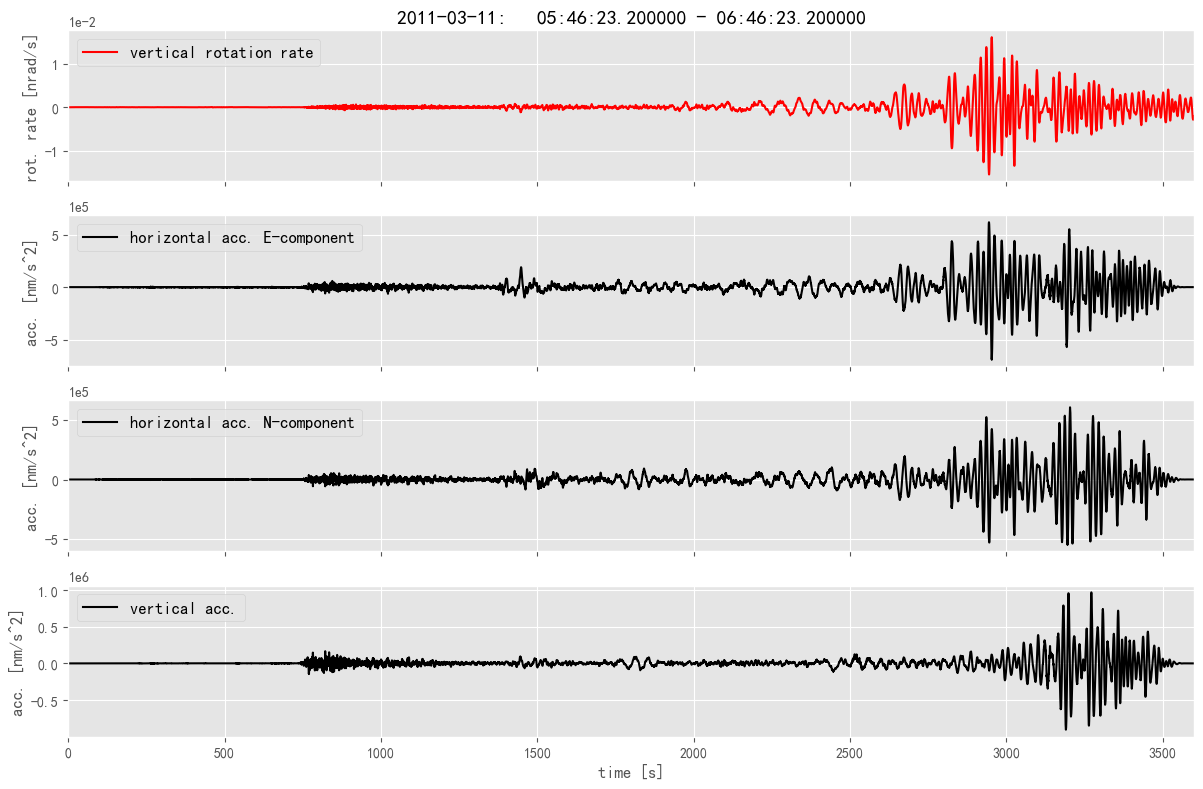

In [14]:
c_fdsn = fdsnClient('IRIS')
cat = read_events("../data/iris_catalog.xml")
event = cat[0]
print(cat)
start = event.origins[0].time
end = start + 3600

AC = read("../data/event_bfg.mseed")
print(RLAS)
print(AC)

RLAS.detrend(type='linear')
RLAS[0].data = RLAS[0].data * 1/6.3191 * 1e-3

AC.detrend(type='linear')
AC.taper(max_percentage=0.05)

paz_sts2 = {'poles': [(-0.0367429 + 0.036754j), (-0.0367429 - 0.036754j)],
            'sensitivity': 0.944019640,
            'zeros': [0j],
            'gain': 1.0}

AC.simulate(paz_remove=paz_sts2, remove_sensitivity=True)

startaim = max([tr.stats.starttime for tr in (AC + RLAS)])
endtaim = min([tr.stats.endtime for tr in (AC + RLAS)])

AC.trim(startaim, endtaim, nearest_sample=True)
RLAS.trim(startaim, endtaim, nearest_sample=True)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex=True)

ax1.set_title(str(start.date) + ':   ' + str(start.time) + " - " + str(end.time))
ax1.plot(RLAS[0].times(), RLAS[0],'r',label='vertical rotation rate')
ax1.set_ylabel('rot. rate [nrad/s]')
ax2.plot(AC[0].times(),AC[0],'k',label='horizontal acc. E-component')
ax2.set_ylabel('acc. [nm/s^2]')
ax3.plot(AC[1].times(),AC[1],'k',label='horizontal acc. N-component')
ax3.set_ylabel('acc. [nm/s^2]')
ax4.plot(AC[2].times(),AC[2],'k',label='vertical acc.')
ax4.set_ylabel('acc. [nm/s^2]')
ax4.set_xlabel('time [s]')

for ax in [ax1,ax2,ax3,ax4]:
    ax.legend(loc=2, prop={"size":12})
    ax.yaxis.major.formatter.set_powerlimits((-1,2))
    ax.set_xlim(0,max(AC[0].times()))

fig.tight_layout()
plt.show()

/home/muly/.local/lib/python3.11/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (1.0) of bandpass is at or above Nyquist (0.625). Applying a high-pass instead.
  warnings.warn(msg)
/tmp/ipykernel_367065/1464154370.py:18: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)


Epicentral distance [m]:  9127350.828896653
Theoretical azimuth [deg]:  329.4079811585143
Theoretical backazimuth [deg]:  37.602787067079454


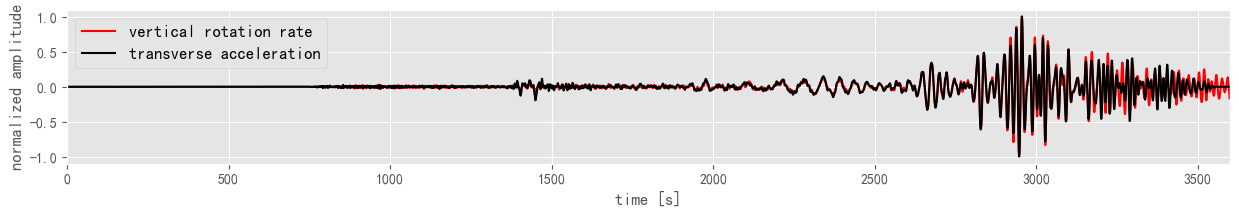

In [17]:
RLAS.decimate(factor=4)
AC.decimate(factor=4)
high_cut = 1.0
low_cut = 0.005

RLAS.filter('bandpass', freqmax=high_cut, freqmin=low_cut, corners=2, zerophase=True)
AC.filter('bandpass', freqmax=high_cut, freqmin=low_cut, corners=2, zerophase=True)

# event location from event info
source_latitude = event.origins[0].latitude
source_longitude = event.origins[0].longitude

# station location (Wettzell)
station_latitude = 49.144001
station_longitude = 12.8782

# theoretical backazimuth and distance
baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

print('Epicentral distance [m]: ', baz[0])
print('Theoretical azimuth [deg]: ', baz[1])
print('Theoretical backazimuth [deg]: ', baz[2])

# rotate
AC.rotate(method='NE->RT',back_azimuth=baz[2])
plt.figure(figsize=(15,2))

ax = plt.subplot(111)
ax.plot(RLAS[0].times(), RLAS[0].data/np.max(np.abs(RLAS[0].data)), 'r', label='vertical rotation rate')
ax.plot(AC[0].times(), AC[0].data/np.max(np.abs(AC[0].data)), 'k', label='transverse acceleration')
ax.legend(loc=2, prop={"size":12})
ax.set_xlabel('time [s]')
ax.set_ylabel('normalized amplitude')
ax.set_xlim(0,max(RLAS[0].times()))

plt.show()

### 2.小波分析

In [ ]:
st = obspy.read("../data/detrend_test_stream.mseed")
tr = st[0]
npts = tr.stats.npts
dt = tr.stats.delta
t = np.linspace(0, dt * npts, npts)
f_min = 1
f_max = 50

scalogram = cwt(tr.data, dt, 8, f_min, f_max)

fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(
    t,
    np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
ax.set_ylabel("Frequency [Hz]")
ax.set_yscale('log')
ax.set_ylim(f_min, f_max)
plt.show()

### 3.波形相关分析